In [1]:
import nltk
nltk.download('wordnet')

##from google.colab import files
#uploaded = files.upload()

[nltk_data] Downloading package wordnet to /home/maad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
import pandas as pd
import gensim
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score, recall_score, roc_auc_score,roc_curve, auc, f1_score
import seaborn as sns
import sklearn

In [3]:
df = pd.read_excel("AllCOmbine.xlsx", sheet_name=None, ignore_index=True, sort=True)
data = pd.concat(df.values(), ignore_index=True, sort=False)

In [4]:
data.isna().sum()

Unnamed: 0    0
Tweet_text    0
Tag           0
dtype: int64

In [5]:
data['Tag'].value_counts()

PT    5491
WB    3244
ST    2663
ED    1935
EN    1728
SP    1718
RE    1551
SI    1505
BN    1004
HT     882
NW     713
GM     656
Name: Tag, dtype: int64

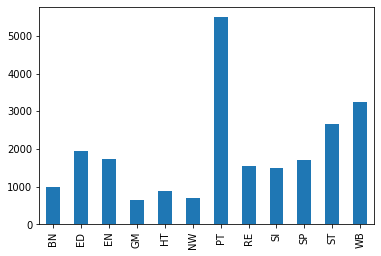

In [6]:
data['Tag'].value_counts().sort_index().plot.bar()

In [7]:
data['Tag'].describe()

count     23090
unique       12
top          PT
freq       5491
Name: Tag, dtype: object

In [8]:
data.head()

Unnamed: 0                                         Tweet_text Tag
0           0  RT @AndrewYNg: Right now economists are debati...  BN
1           1  An investment in knowledge pays the best inter...  WB
2           2  RT @IMustajabgohar: Sino Tires to Invest $600 ...  BN
3           3  RT @IKLover1992: 22 Years struggle has finally...  PT
4           4  RT @insaafian92107: Trade deficit dips 14pc to...  BN

In [9]:
data.shape

(23090, 3)

In [10]:
my_tags = ['ST', 'PT', 'HT', 'BN', 'ED', 'SP', 'EN', 'SI', 'RE', 'GM', 'NW', 'WB']

In [11]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text_to_preprocess):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text_to_preprocess, pos='v'))

def preprocess(text_to_preprocess):
    result = []
    for token in gensim.utils.simple_preprocess(text_to_preprocess):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)

In [12]:
data['Tweet_text'] = data['Tweet_text'].map(preprocess)


In [13]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['Tweet_text'], data['Tag'], stratify=data['Tag'],random_state = 0)

In [14]:
print("train_x shape",train_x.shape)
print("train_y shape",train_y.shape)
print("test_x shape",test_x.shape)
print("test_y shape",test_y.shape)

train_x shape (17317,)
train_y shape (17317,)
test_x shape (5773,)
test_y shape (5773,)


In [15]:
col=['Tag']
train_y = pd.DataFrame(train_y)
train_y['Tag'].value_counts()

PT    4118
WB    2433
ST    1997
ED    1451
EN    1296
SP    1288
RE    1163
SI    1129
BN     753
HT     662
NW     535
GM     492
Name: Tag, dtype: int64

In [16]:
col=['Tag']
test_y = pd.DataFrame(test_y)
test_y['Tag'].value_counts()

PT    1373
WB     811
ST     666
ED     484
EN     432
SP     430
RE     388
SI     376
BN     251
HT     220
NW     178
GM     164
Name: Tag, dtype: int64

In [17]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y.values)
test_y = encoder.fit_transform(test_y.values)

/home/maad/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maad/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(data['Tweet_text'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
                vocabulary=None)

In [19]:
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xtest_count =  count_vect.transform(test_x)

In [20]:
def train_model(clf, x_train, y_train, x_test, y_test, verbose=False):
    clf = clf.fit(x_train, y_train)    
    pred = clf.predict(x_test)    
    
    if verbose:
        tweet = "Amir took 5 wicket in yesterday 20 20 match at national stadium"
        print("Predicting tweet: {}".format(tweet))
        custom_pred = clf.predict(count_vect.transform([tweet]))
        print("Result: {}".format(encoder.inverse_transform(custom_pred)))
    
    return metrics.accuracy_score(pred, y_test)

In [21]:
def formatAccuracy(acc):
    return round(acc*100, 3)

In [23]:
print ("~ Using Naive Bayes ~ ")
NBModel = naive_bayes.MultinomialNB(alpha=0.1)
accuracyNB = train_model(NBModel, xtrain_count, train_y, xtest_count, test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracyNB)))
NBModel = NBModel.fit(xtrain_count, train_y) 
pred = NBModel.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))

print('Training acc : ',accuracy_score(train_y, NBModel.predict(xtrain_count)))
print(classification_report(test_y, pred,target_names=my_tags))




~ Using Naive Bayes ~ 
Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 66.395%
roc_auc_score : 0.7985733697773184
Training acc :  0.8801178033146619
              precision    recall  f1-score   support

          ST       0.50      0.53      0.51       251
          PT       0.51      0.50      0.51       484
          HT       0.64      0.62      0.63       432
          BN       0.47      0.57      0.51       164
          ED       0.74      0.77      0.75       220
          SP       0.31      0.42      0.36       178
          EN       0.85      0.80      0.82      1373
          SI       0.77      0.87      0.81       388
          RE       0.38      0.34      0.36       376
          GM       0.86      0.85      0.85       430
          NW       0.72      0.73      0.72       666
          WB       0.57      0.55      0.56       811

    accuracy                           0.66      5773
   macro avg       0.61      0.63 

In [24]:
#SVC
print()
print ("~ Using Linear SVC ~ ")
SVCModel = svm.LinearSVC(C=0.1)
accuracySVC = train_model(SVCModel, xtrain_count, train_y, xtest_count, test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracySVC)))
SVCModel = SVCModel.fit(xtrain_count, train_y) 
pred = SVCModel.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))
print('Training acc : ',accuracy_score(train_y, SVCModel.predict(xtrain_count)))
print(classification_report(test_y, pred,target_names=my_tags))


~ Using Linear SVC ~ 
Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 68.803%
roc_auc_score : 0.7947552939904344
Training acc :  0.9051798810417508
              precision    recall  f1-score   support

          ST       0.61      0.53      0.57       251
          PT       0.51      0.51      0.51       484
          HT       0.67      0.62      0.65       432
          BN       0.62      0.49      0.54       164
          ED       0.82      0.77      0.80       220
          SP       0.35      0.20      0.26       178
          EN       0.81      0.86      0.83      1373
          SI       0.86      0.89      0.87       388
          RE       0.54      0.30      0.38       376
          GM       0.91      0.84      0.87       430
          NW       0.71      0.78      0.74       666
          WB       0.50      0.65      0.56       811

    accuracy                           0.69      5773
   macro avg       0.66      0.62 

[[ 133    5   11    0    2    5   36    0    3    3   20   33]
 [   7  245   19   29    0    3    8    4    7    2   84   76]
 [   4   21  269    5    2   15   11    2    3    6   14   80]
 [   0   25    2   80    0    1    8    2    6    2   13   25]
 [   0    2    4    0  170    0   10    1    4    1    7   21]
 [   8    9   20    2    1   36   37    0   12    2   15   36]
 [  22   20    7    0    9   16 1178    4   27    9   13   68]
 [   0    1    0    2    2    1    5  344    3    0    1   29]
 [  13   13   11    5    2    7   99    9  111    2   24   80]
 [   0    1   13    2    1    4    7    0    3  362    0   37]
 [  13   55   11    1    4    8   11    0    5    3  520   35]
 [  17   80   35    4   14    7   46   34   20    8   22  524]]


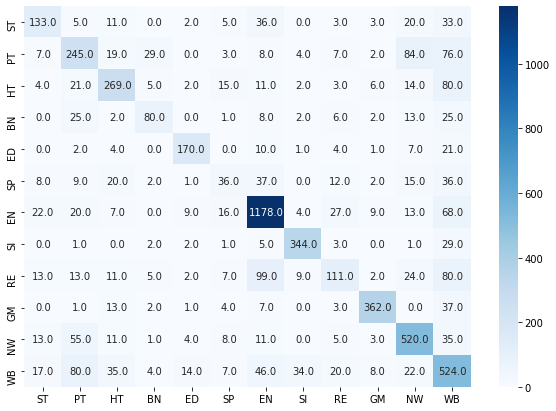

In [25]:
import seaborn as sn
con = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(con, index =my_tags ,
                  columns = my_tags)
print(con)
plt.figure(figsize = (10,7))
za = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt=".1f",cmap=plt.cm.Blues)

figure = za.get_figure()    
figure.savefig('svm_conf.png', dpi=500,bbox_inches = 'tight')


SVC


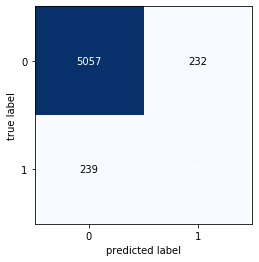

In [24]:
print('SVC')

cm = confusion_matrix(y_target=test_y, 
                      y_predicted=pred, 
                      binary=True, 
                      positive_label=1)


fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()



In [26]:
#LR
print()
print ("~ Using Logistic Regression ~ ")
LRModel = linear_model.LogisticRegression(C=1.0, solver='lbfgs', multi_class='multinomial')
accuracySVC = train_model(LRModel, xtrain_count, train_y, xtest_count, test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracySVC)))
LRModel = LRModel.fit(xtrain_count, train_y) 
pred = LRModel.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))
print('Training acc : ', accuracy_score(train_y, LRModel.predict(xtrain_count)))
print(classification_report(test_y, pred,target_names=my_tags))


~ Using Logistic Regression ~ 


/home/maad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 68.041%
roc_auc_score : 0.7894984060954315
Training acc :  0.9095686319801352
              precision    recall  f1-score   support

          ST       0.65      0.52      0.58       251
          PT       0.51      0.50      0.51       484
          HT       0.63      0.62      0.63       432
          BN       0.66      0.43      0.52       164
          ED       0.84      0.75      0.79       220
          SP       0.34      0.25      0.29       178
          EN       0.82      0.85      0.83      1373
          SI       0.89      0.84      0.86       388
          RE       0.50      0.32      0.39       376
          GM       0.91      0.82      0.86       430
          NW       0.70      0.75      0.72       666
          WB       0.50      0.67      0.57       811

    accuracy                           0.68      5773
   macro avg       0.66      0.61      0.63      5773
wei

/home/maad/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [27]:
import seaborn as sn
con = confusion_matrix(test_y, pred)
df_cm = pd.DataFrame(con, index =my_tags ,
                  columns = my_tags)
print(con)
plt.figure(figsize = (10,7))
za = sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt=".1f",cmap=plt.cm.Blues)

figure = za.get_figure()    
figure.savefig('svm_conf.png', dpi=500,bbox_inches = 'tight')


[[ 130    6    8    0    0    8   31    0    6    3   23   36]
 [   7  244   25   22    0    3    8    3   11    0   83   78]
 [   3   17  270    3    1   19   11    0    7    8   12   81]
 [   0   25    4   70    0    2    8    1   10    2   16   26]
 [   0    3    5    0  164    1    9    1    5    1    8   23]
 [   5    9   23    0    0   45   35    0   11    2   14   34]
 [  19   19    8    0    8   20 1169    4   37    7   11   71]
 [   0    1    3    0    2    1    7  325    7    0    1   41]
 [  11   12   14    4    2    8   95    7  119    2   25   77]
 [   1    1   15    1    1    8    8    0    3  351    1   40]
 [  13   70   13    2    4    7    8    0    6    3  501   39]
 [  12   70   42    4   13   12   45   25   18    8   22  540]]


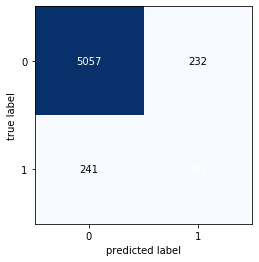

In [26]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
cm = confusion_matrix(y_target=test_y, 
                      y_predicted=pred, 
                      binary=True, 
                      positive_label=1)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

#


~ Using Random Forest Classifier ~
Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 66.828%
roc_auc_score : 0.7698843889414326
Training acc :  0.8950164578160189
              precision    recall  f1-score   support

          ST       0.69      0.47      0.56       251
          PT       0.58      0.51      0.54       484
          HT       0.74      0.51      0.60       432
          BN       0.65      0.30      0.41       164
          ED       0.83      0.75      0.79       220
          SP       0.38      0.11      0.17       178
          EN       0.82      0.88      0.85      1373
          SI       0.84      0.87      0.86       388
          RE       0.69      0.19      0.29       376
          GM       0.85      0.80      0.82       430
          NW       0.68      0.74      0.71       666
          WB       0.41      0.71      0.52       811

    accuracy                           0.67      5773
   macro avg       0.

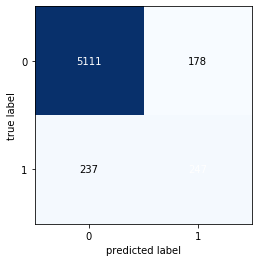

In [27]:
#RF
print()
print ("~ Using Random Forest Classifier ~")
RFModel = RandomForestClassifier(n_estimators=500, max_depth=200, random_state=0)
accuracyRF = train_model(RFModel,xtrain_count, train_y, xtest_count, test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracyRF)))
RFModel = RFModel.fit(xtrain_count, train_y) 
pred = RFModel.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))
print('Training acc : ', accuracy_score(train_y, RFModel.predict(xtrain_count)))
print(classification_report(test_y, pred,target_names=my_tags))

print("Rf")
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
cm = confusion_matrix(y_target=test_y, 
                      y_predicted=pred, 
                      binary=True, 
                      positive_label=1)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()



In [29]:
from sklearn.ensemble import GradientBoostingClassifier
GB=GradientBoostingClassifier(random_state=0)
accuracyGB = train_model(GB,xtrain_count, train_y, xtest_count, test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracyGB)))
GB = GB.fit(xtrain_count, train_y) 
pred = GB.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))
train_acc= accuracy_score(train_y, GB.predict(xtrain_count))
print('train_acc',train_acc)
print(classification_report(test_y, pred,target_names=my_tags))



Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 64.455%
roc_auc_score : 0.760669636351368
train_acc 0.7360397297453369
              precision    recall  f1-score   support

          ST       0.67      0.53      0.59       251
          PT       0.53      0.45      0.49       484
          HT       0.78      0.49      0.60       432
          BN       0.56      0.27      0.37       164
          ED       0.81      0.76      0.78       220
          SP       0.40      0.11      0.17       178
          EN       0.82      0.87      0.84      1373
          SI       0.83      0.85      0.84       388
          RE       0.66      0.23      0.34       376
          GM       0.92      0.76      0.84       430
          NW       0.69      0.67      0.68       666
          WB       0.35      0.67      0.46       811

    accuracy                           0.64      5773
   macro avg       0.67      0.56      0.58      5773
weighted a


~ Using NN ~ 
Predicting tweet: Amir took 5 wicket in yesterday 20 20 match at national stadium
Result: ['SP']
Accuracy: 64.992%
roc_auc_score : 0.7728475586169802
Training acc :  0.952416700352255
              precision    recall  f1-score   support

          ST       0.56      0.50      0.53       251
          PT       0.49      0.49      0.49       484
          HT       0.60      0.58      0.59       432
          BN       0.35      0.40      0.38       164
          ED       0.75      0.70      0.73       220
          SP       0.28      0.19      0.23       178
          EN       0.80      0.84      0.82      1373
          SI       0.78      0.82      0.80       388
          RE       0.36      0.31      0.33       376
          GM       0.87      0.82      0.84       430
          NW       0.67      0.71      0.69       666
          WB       0.55      0.57      0.56       811

    accuracy                           0.65      5773
   macro avg       0.59      0.58      0.58

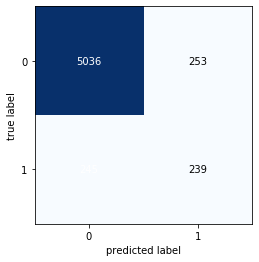

In [30]:
#NN
print()
print ("~ Using NN ~ ")
NNModel = MLPClassifier(activation='relu', max_iter=800, solver='lbfgs', learning_rate_init=0.005, hidden_layer_sizes=(46, 44), random_state=1)
accuracyNN = train_model(NNModel, xtrain_count.toarray(), train_y, xtest_count.toarray(), test_y, verbose=True)
print ("Accuracy: {}%".format(formatAccuracy(accuracyNN)))
NNModel = NNModel.fit(xtrain_count, train_y) 
pred = NNModel.predict(xtest_count)
from sklearn.metrics import roc_curve
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = sklearn.preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)
print("roc_auc_score :",multiclass_roc_auc_score(test_y,pred))
print('Training acc : ', accuracy_score(train_y,NNModel.predict(xtrain_count)))
print(classification_report(test_y, pred,target_names=my_tags))
cm = confusion_matrix(y_target=test_y, 
                      y_predicted=pred, 
                      binary=True, 
                      positive_label=1)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()


In [0]:
def majority_voting(x_train, y_train, x_test, y_test):    
    NBPredict = NBModel.predict(x_test)
    SVCPredict = SVCModel.predict(x_test)
    LRPredict = LRModel.predict(x_test)
    RFPredict = RFModel.predict(x_test)
    NNPredict = NNModel.predict(x_test)
    GBPredict = GB.predict(x_test)
#    
    votingPred = []
    
    for i in range(len(y_test)):
        for_pred = [NBPredict[i], LRPredict[i], SVCPredict[i], RFPredict[i], NNPredict[i],GBPredict[i]]
        highest = for_pred[0]
        count = 0
        for current_pred in for_pred: 
            new_count = 0
            for test_pred in for_pred:
                if current_pred == test_pred:
                    new_count = new_count + 1
            if new_count > count:
                highest = current_pred
                count = new_count
        votingPred.append(highest)
           
    return metrics.accuracy_score(votingPred, y_test)

In [0]:
def majorityVotingPredictor(inputX):
    NBPredict = NBModel.predict(count_vect.transform([inputX]))
    SVCPredict = SVCModel.predict(count_vect.transform([inputX]))
    LRPredict = LRModel.predict(count_vect.transform([inputX]))
    RFPredict = RFModel.predict(count_vect.transform([inputX]))
    NNPredict = NNModel.predict(count_vect.transform([inputX]))
    GBPredict = GB.predict(count_vect.transform([inputX]))
    
    print("NB: {}".format(encoder.inverse_transform(NBPredict)))
    print("SVC: {}".format(encoder.inverse_transform(SVCPredict)))
    print("LR: {}".format(encoder.inverse_transform(LRPredict)))
    print("RF: {}".format(encoder.inverse_transform(RFPredict)))
    print("NN: {}".format(encoder.inverse_transform(NNPredict)))
    print("GB: {}".format(encoder.inverse_transform(GBPredict)))
    
    for_pred = [NBPredict, LRPredict, SVCPredict, RFPredict, NNPredict,GBPredict]
    highest = for_pred[0]
    count = 0
    for current_pred in for_pred: 
        new_count = 0
        for test_pred in for_pred:
            if current_pred == test_pred:
                new_count = new_count + 1
        if new_count > count:
            highest = current_pred
            count = new_count
    
    return encoder.inverse_transform(highest)

In [33]:
print()
print ("~ Using Majority Voting ~ ")
votingAccuracy = majority_voting(xtrain_count, train_y, xtest_count, test_y)
print ("Accuracy: {}%".format(formatAccuracy(votingAccuracy)))


~ Using Majority Voting ~ 
Accuracy: 69.479%


In [35]:
custom_input = "Watching Movie with Friends"
print("Predicting tweet: {}".format(custom_input))
result = majorityVotingPredictor(preprocess(custom_input))
print("Majority Voting: {}".format(result))

Predicting tweet: Watching Movie with Friends
NB: ['EN']
SVC: ['EN']
LR: ['EN']
RF: ['EN']
NN: ['EN']
GB: ['EN']
Majority Voting: ['EN']
